## Looking for bias in the error

In this notebook we are looking at whether there is a bias in the mean error for
several lossy compressors, including 3 varients of the the zfp compressor. This
relates to the work in:

Dorit M. Hammerling, Allison H. Baker, Alexander Pinard, Peter Lindstrom, "A
collaborative effort to improve lossy compression for climate data,” in 2019
IEEE/ACM 5th International Workshop on Data Analysis and Reduction for Big
Scientific Data (DRBSD-5), Denver, CO, USA, 2019, pp. 16-22
(doi:10.1109/DRBSD-549595.2019.00008).

In particular, ZFP 0.5.3 shows a bias that we do not see with the newer varients
ZFP-beta and ZFP-round. The sample data resides on NCAR's glade storage, and we
use the NCAR Jupyter hub.

First we setup the environment and start a dask cluster. (Make sure you use an appropriate kernel: NPL 2023a is a good choice.)


In [1]:
# Make sure you are using an appropriate kernel ,like NPL 2023a kernel

# Add ldcpy root to system path (MODIFY FOR YOUR LDCPY CODE LOCATION)
import sys

sys.path.insert(0, '../../../')
#sys.path.insert(0, '/glade/u/home/abaker/repos/my_ldcpy')
import ldcpy

# Display output of plots directly in Notebook
%matplotlib inline
# Automatically reload module if it is editted
%reload_ext autoreload
%autoreload 2

# silence warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
# customize for your job
import dask
from dask_jobqueue import PBSCluster

cluster = PBSCluster(
    # Basic job directives
    job_name='ldcpy-bias',
    queue='casper',
    walltime='60:00',
    # Make sure you change the project code if running this notebook!!
    account='NTDD0004',
    log_directory='dask-logs',
    # These settings impact the resources assigned to the job
    cores=1,
    memory='10GiB',
    resource_spec='select=1:ncpus=1:mem=10GB',
    # These settings define the resources assigned to a worker
    processes=1,
    # This controls where Dask will write data to disk if memory is exhausted
    local_directory='/local_scratch/pbs.$PBS_JOBID/dask/spill',
    # This specifies which network interface the cluster will use
    interface='ext',
)

In [3]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N ldcpy-bias
#PBS -q casper
#PBS -A NTDD0004
#PBS -l select=1:ncpus=1:mem=10GB
#PBS -l walltime=60:00
#PBS -e dask-logs/
#PBS -o dask-logs/

/glade/u/apps/opt/conda/envs/npl-2023a/bin/python -m distributed.cli.dask_worker tcp://128.117.208.118:34173 --nthreads 1 --memory-limit 10.00GiB --name dummy-name --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask/spill --interface ext



In [4]:
from dask.distributed import Client

# Attach a "client" to our created cluster
client = Client(cluster)

client

<Client: 'tcp://128.117.208.118:34173' processes=0 threads=0, memory=0 B>

In [5]:
# cluster.scale(8)
# Block progress until workers have spawned (optional - typically only in demos and benchmarks!)
# cluster.wait_for_workers(8)

cluster.adapt(minimum_jobs=1, maximum_jobs=20)

In [6]:
cluster.workers

{'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>}

In [7]:
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
2888258.casper* abaker   jhublog* cr-login-*  22945   1   1    4gb 720:0 R 20:14
2893924.casper* abaker   htc      ldcpy-cam*  63825   1   1   10gb 01:00 R 00:07
2894264.casper* abaker   htc      ldcpy-cam*    --    1   1   10gb 01:00 Q   --  


In [8]:
# load the first 86 years of daily surface temperature (TS) data - this has been compressed with fpzip
col_TS_lens = ldcpy.open_datasets(
    "cam-fv",
    ["TS"],
    [
        "/glade/campaign/cisl/asap/ldcpy_sample_data/lens/orig/TS.daily.19200101-20051231.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/lens/lossy/c.TS.daily.19200101-20051231.nc",
    ],
    ["orig", "fpzip"],
    chunks={"time": 500},
)
col_TS_lens

dataset size in GB 11.10



<xarray.Dataset>
Dimensions:     (collection: 2, time: 25100, lat: 192, lon: 288)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 1920-01-01 00:00:00 ... 1988-10-07 00:00:00
    cell_area   (lat, collection, lon) float64 dask.array<chunksize=(192, 1, 288), meta=np.ndarray>
  * collection  (collection) <U5 'orig' 'fpzip'
Data variables:
    TS          (collection, time, lat, lon) float32 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
Attributes: (12/16)
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys0219
    ...               ...
    history:          Tue Nov  3 13:56:03 2020: ncks -L 5 TS.daily.19200101-2...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...
    cell_measures:    area: cell_area
    data_type:        cam-fv
    file_size:        {'orig': 3962086636, 'fpzip': 1330827000}
    weighted:         True

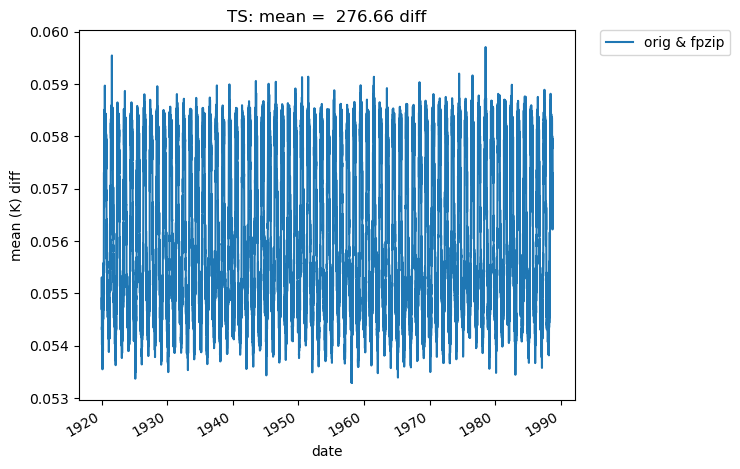

In [9]:
# Time-series plot of TS mean in ds orig dataset, grouped by day of year
ldcpy.plot(
    col_TS_lens,
    "TS",
    sets=["orig", "fpzip"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

That the above error is all positive makes sense because fpzip truncates -
meaning that it will be less than the original. We can see that in this spatial
plot as well.


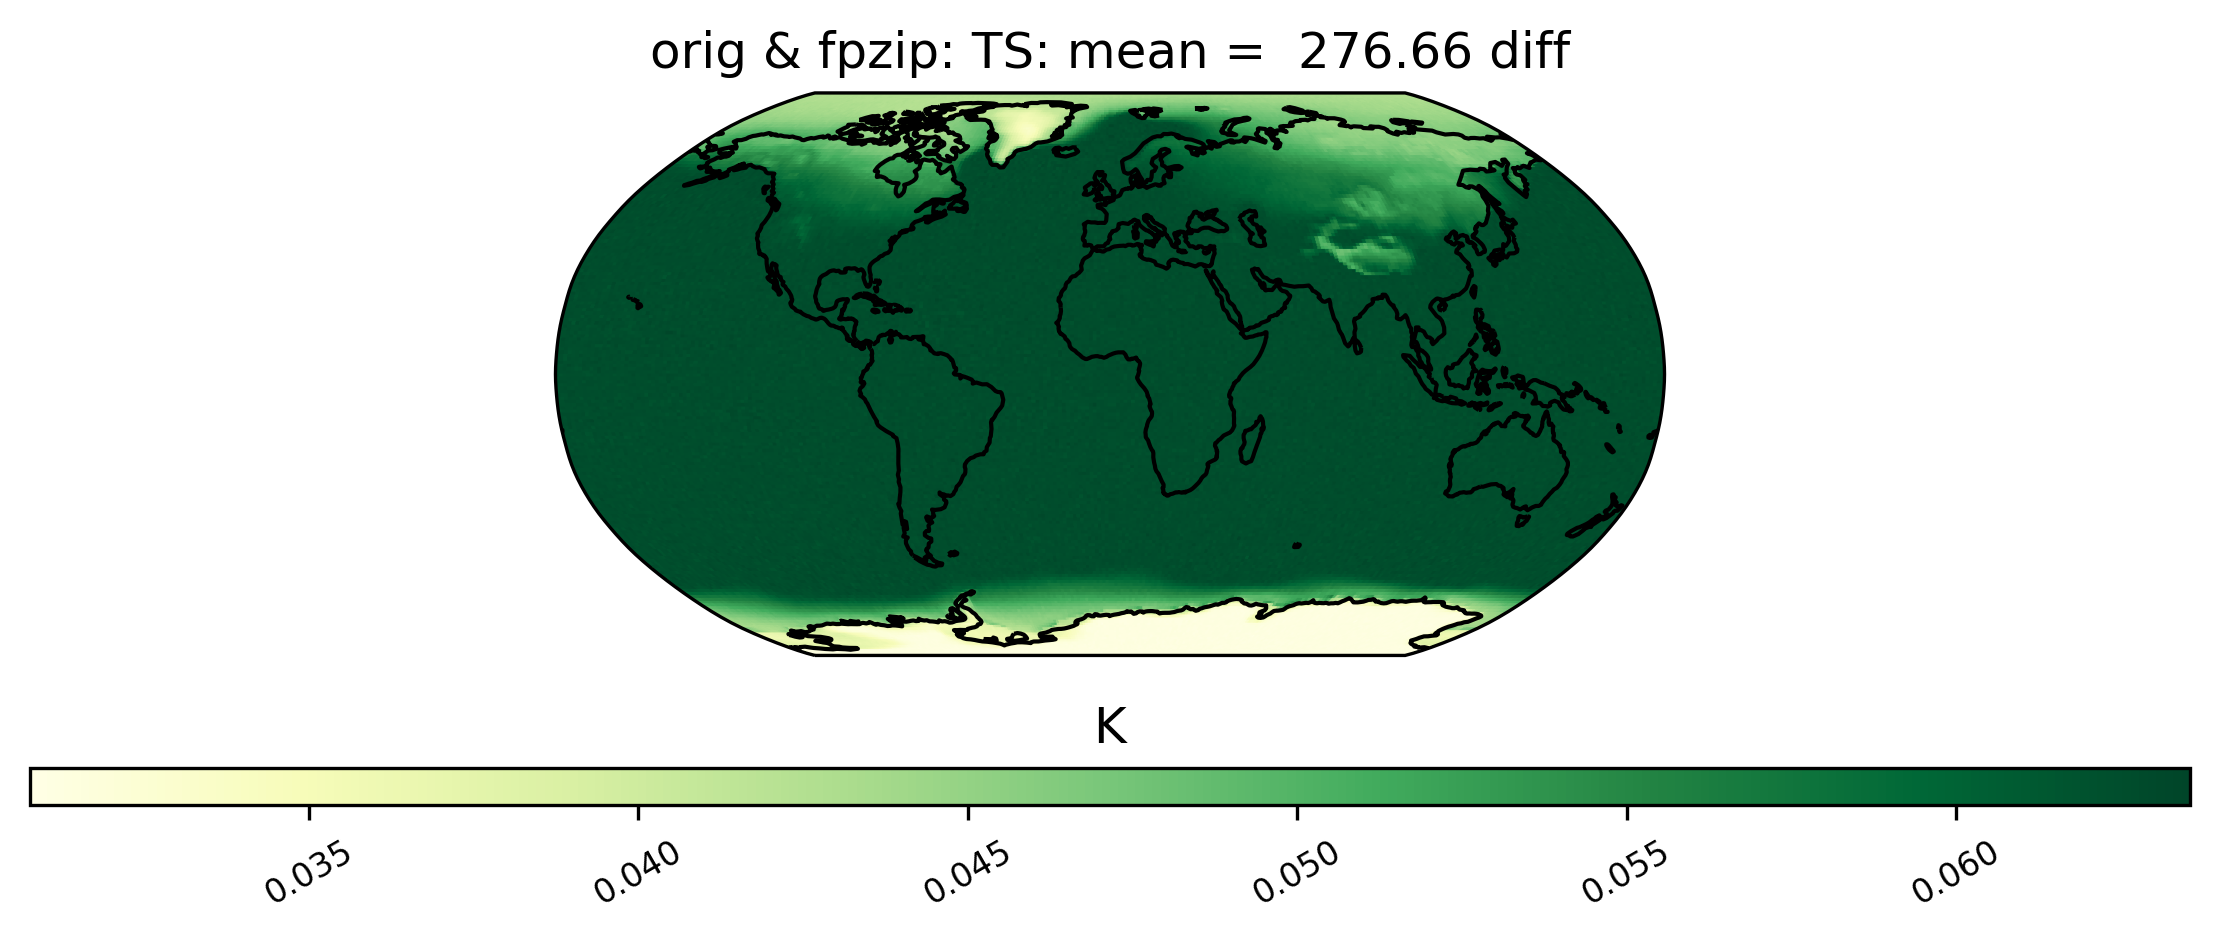

In [10]:
ldcpy.plot(
    col_TS_lens,
    "TS",
    sets=["orig", "fpzip"],
    calc="mean",
    calc_type="diff",
    color="YlGn",
)

In [11]:
del col_TS_lens

In [12]:
# now load some TS data compressed with zfp 0.5.3 and sz compressors
col_TS_cageo = ldcpy.open_datasets(
    "cam-fv",
    ["TS"],
    [
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/orig/b.e11.B20TRC5CNBDRD.f09_g16.030.cam.h1.TS.19200101-20051231.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/zfp1.0.TS.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/zfp0.1.TS.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/zfp0.01.TS.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/sz1.0.TS.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/sz0.1.TS.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/sz0.01.TS.nc",
    ],
    ["orig", "zfp1.0", "zfp0.1", "zfp0.01", "sz1.0", "sz0.1", "sz0.01"],
    chunks={"time": 500},
)
col_TS_cageo

dataset size in GB 38.87



<xarray.Dataset>
Dimensions:     (collection: 7, time: 25100, lat: 192, lon: 288)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 1920-01-01 00:00:00 ... 1988-10-07 00:00:00
    cell_area   (lat, collection, lon) float64 dask.array<chunksize=(192, 1, 288), meta=np.ndarray>
  * collection  (collection) <U7 'orig' 'zfp1.0' 'zfp0.1' ... 'sz0.1' 'sz0.01'
Data variables:
    TS          (collection, time, lat, lon) float32 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
Attributes: (12/16)
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.B20TRC5CNBDRD.f09_g16.030
    title:            UNSET
    logname:          mai
    host:             ys0110
    ...               ...
    history:          Wed Oct 29 04:21:35 2014: ncks -F -d time,1,31390 b.e11...
    NCO:              4.4.4
    cell_measures:    area: cell_area
    data_type:        cam-fv
    file_size:        {'orig': 4041565162, 'zfp1.0': 6952629955, 'zfp0.1': 69...
    weighted:         True

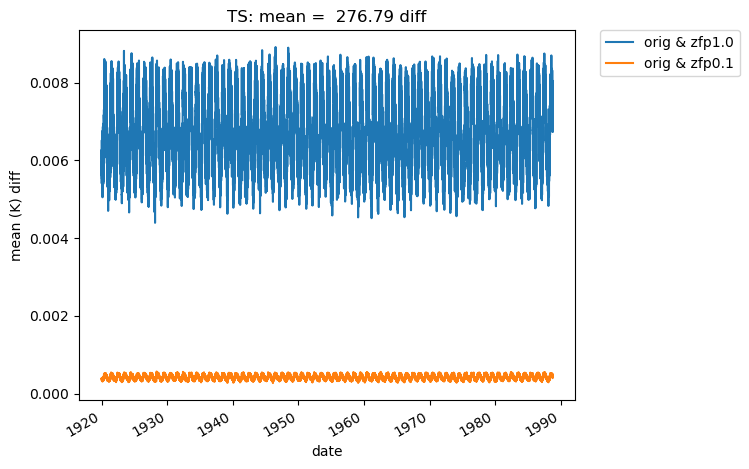

In [13]:
# Time-series plot of TS mean diff from orig with zfp 0.5.3
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "zfp1.0", "zfp0.1"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

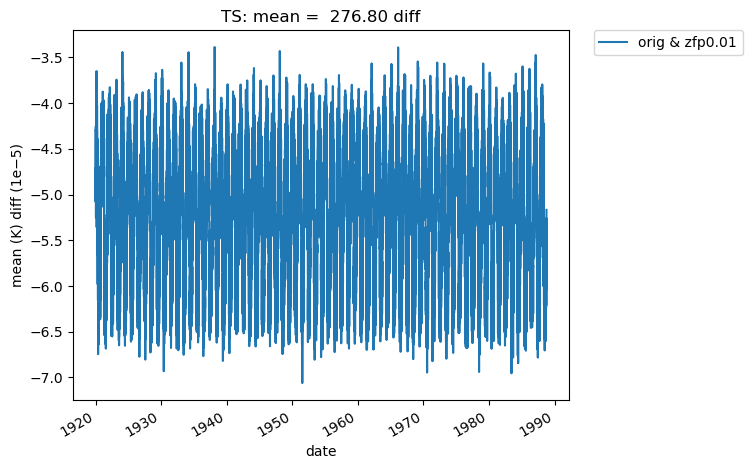

In [14]:
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "zfp0.01"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

You can see the average error at each time slice (above) is all postive for 1.0
and 0.1 tolerances. The tolerance 0.01 results in all negative error. If we look
at the corresponding spatial plots, we can see that there is negative error but
it is less widespread than the positive for 1.0 and 0.1 (and the opposite for
0.01). The reason for ZFP 0.5.3's behavior was explained in the paper referenced
above.


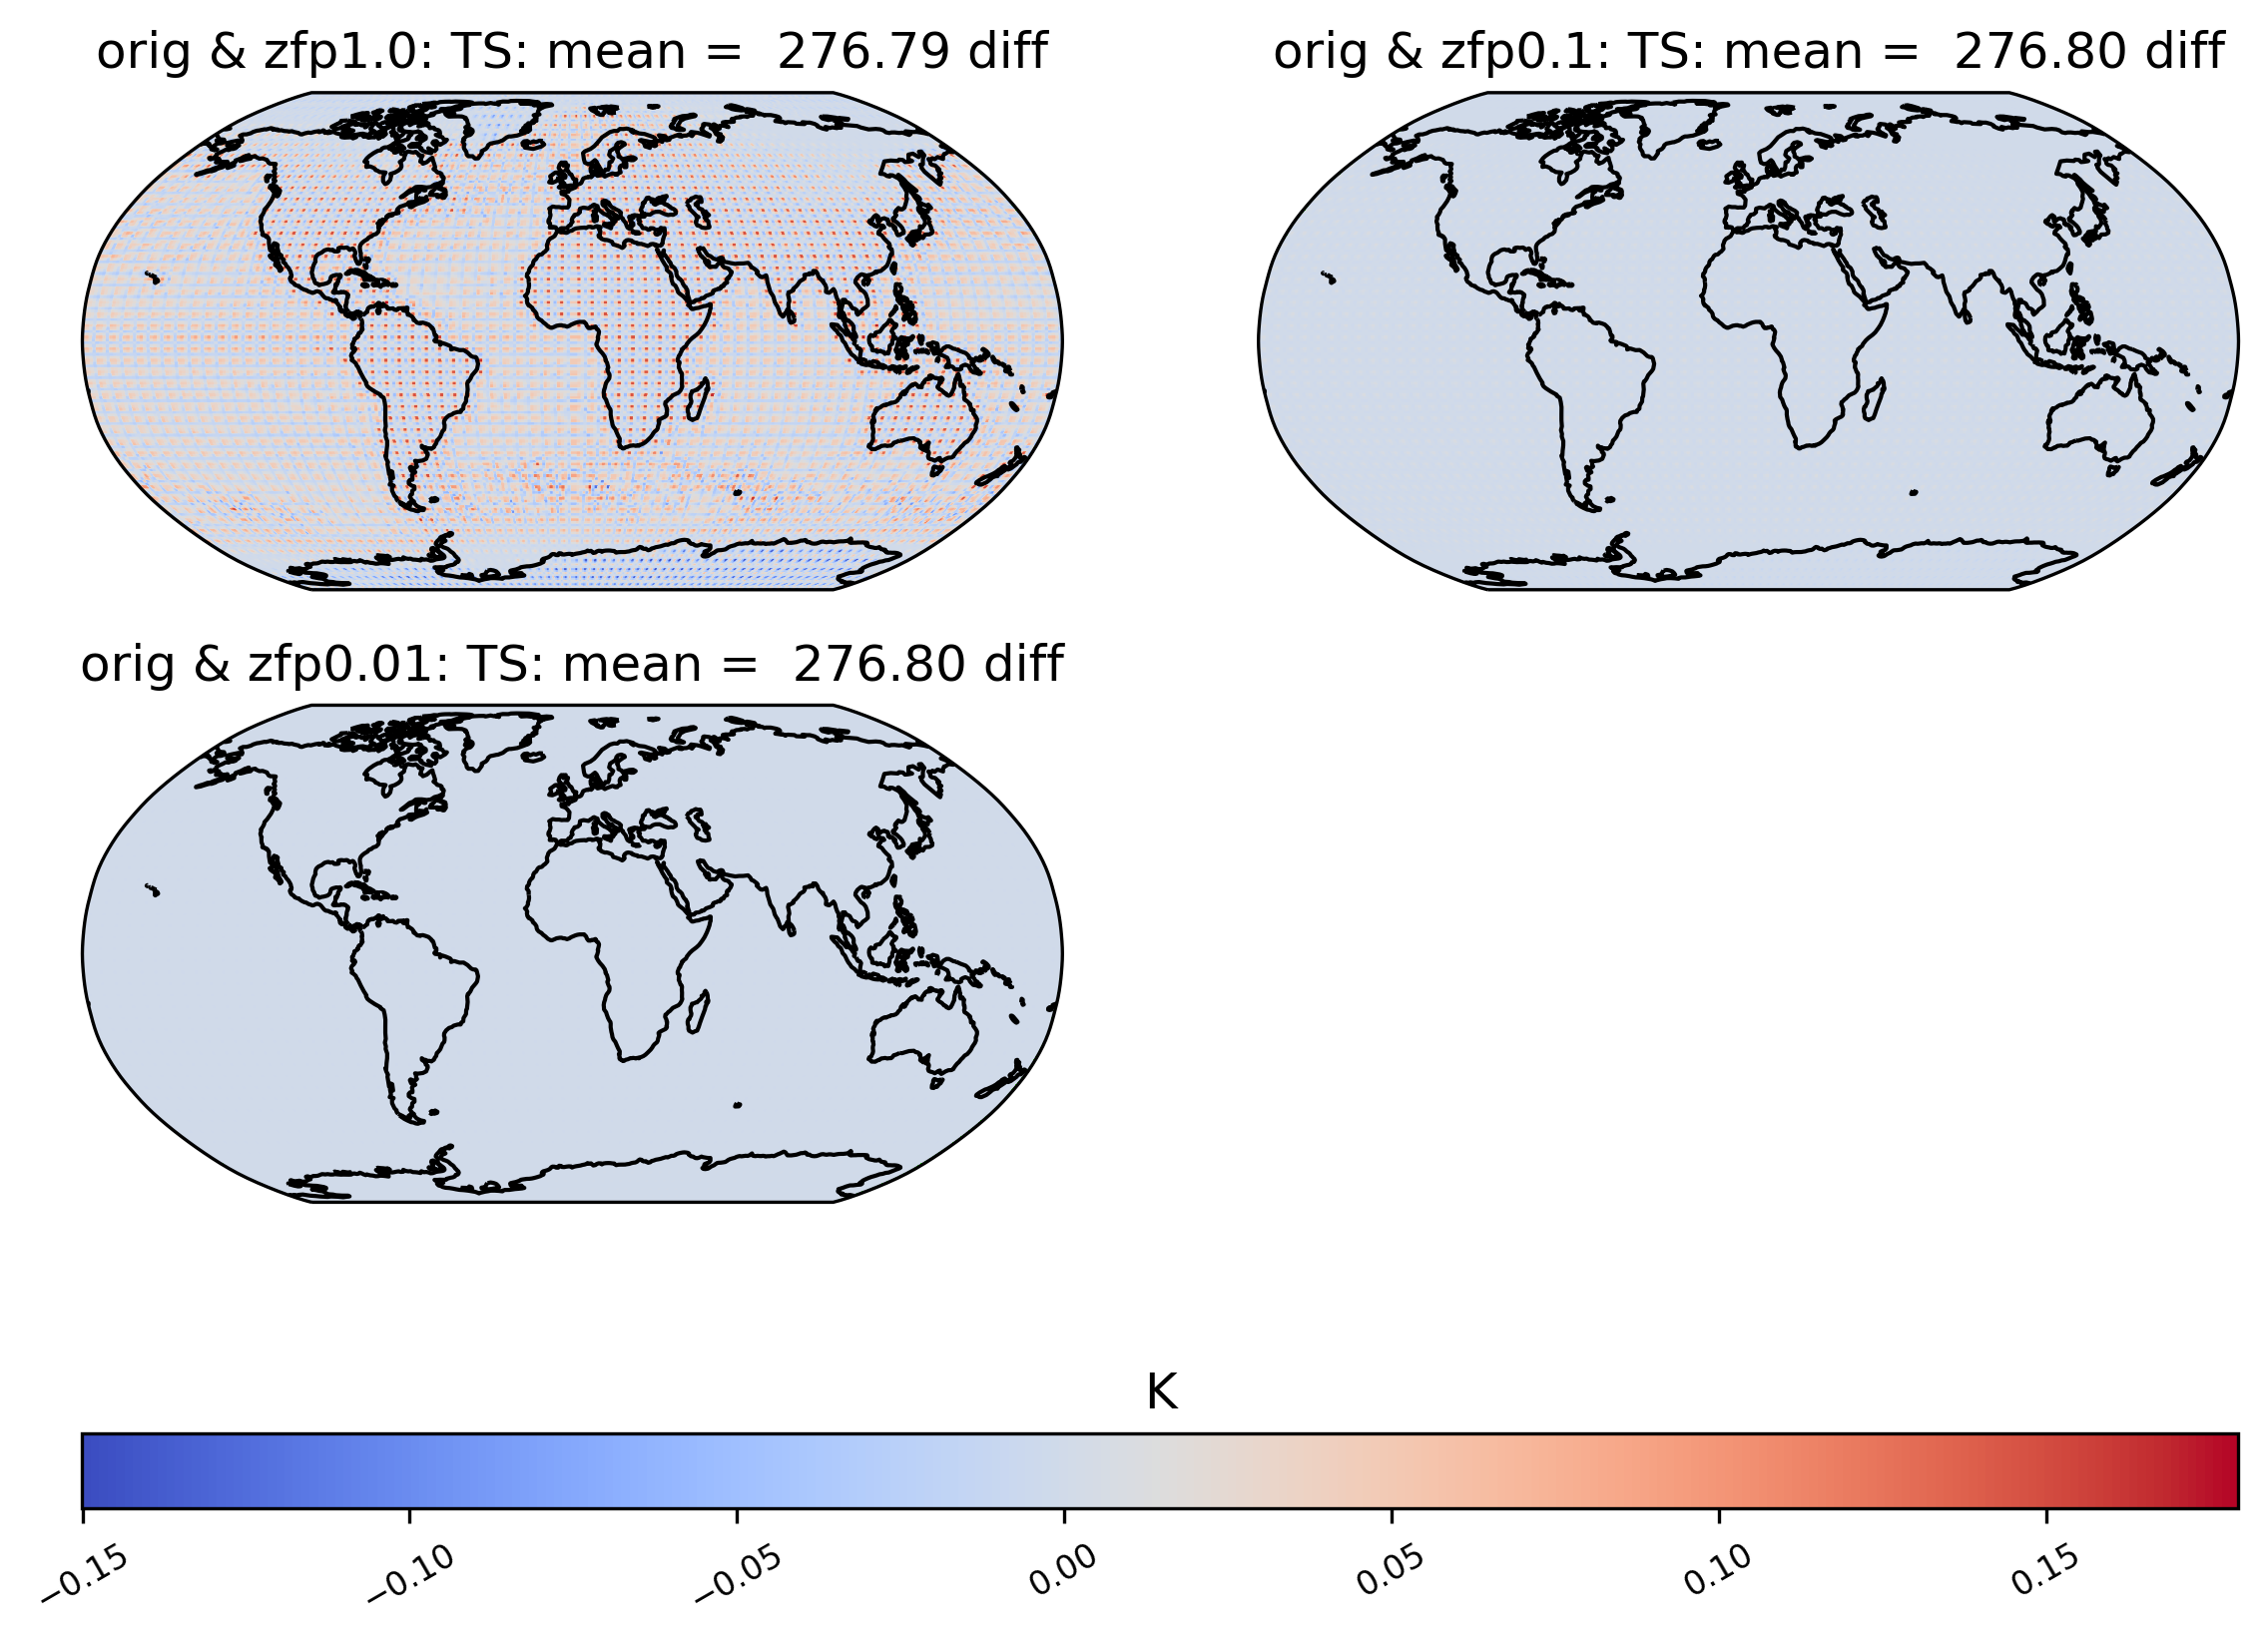

In [15]:
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "zfp1.0", "zfp0.1", "zfp0.01"],
    calc="mean",
    calc_type="diff",
)

When you do three plots together, they share the same color bar, so it may be
difficult to see features with the smaller tolerances. So we replot those below.


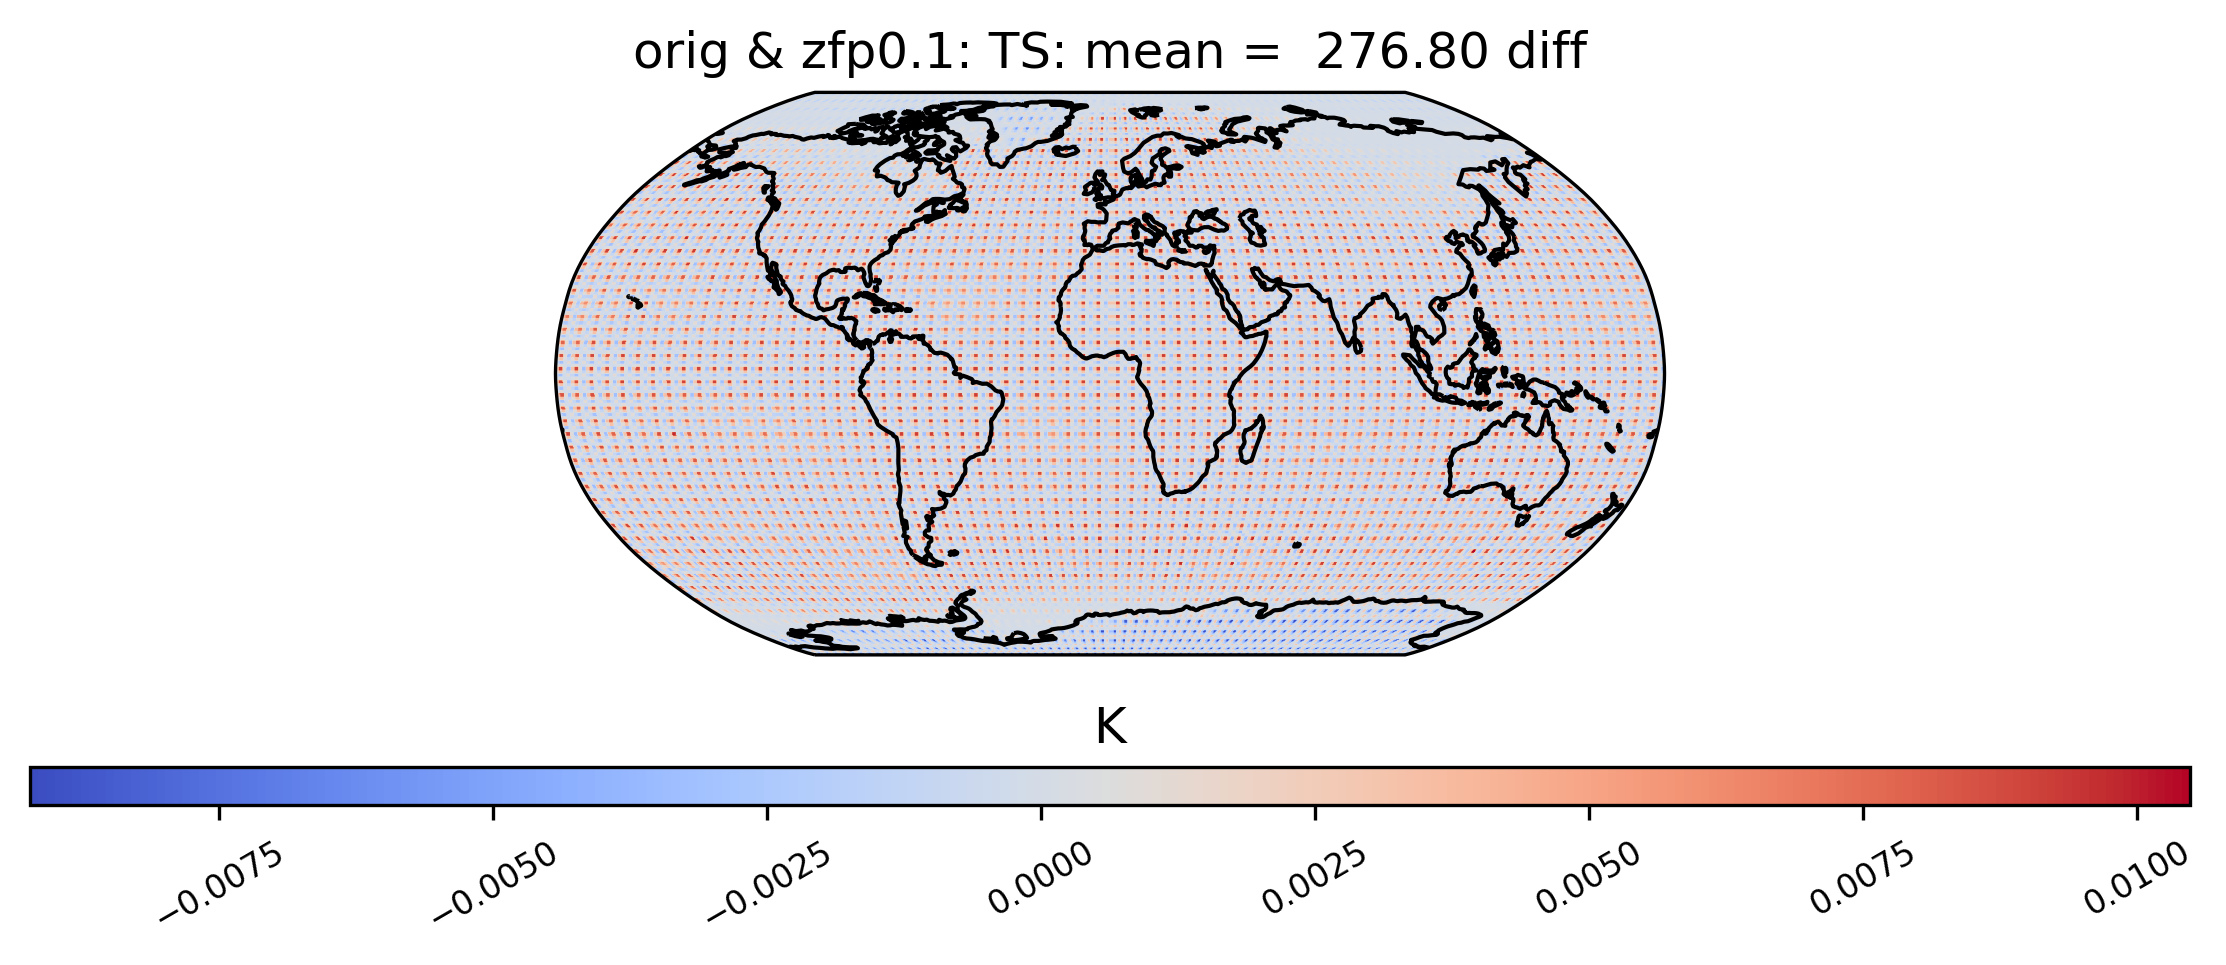

In [16]:
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "zfp0.1"],
    calc="mean",
    calc_type="diff",
)

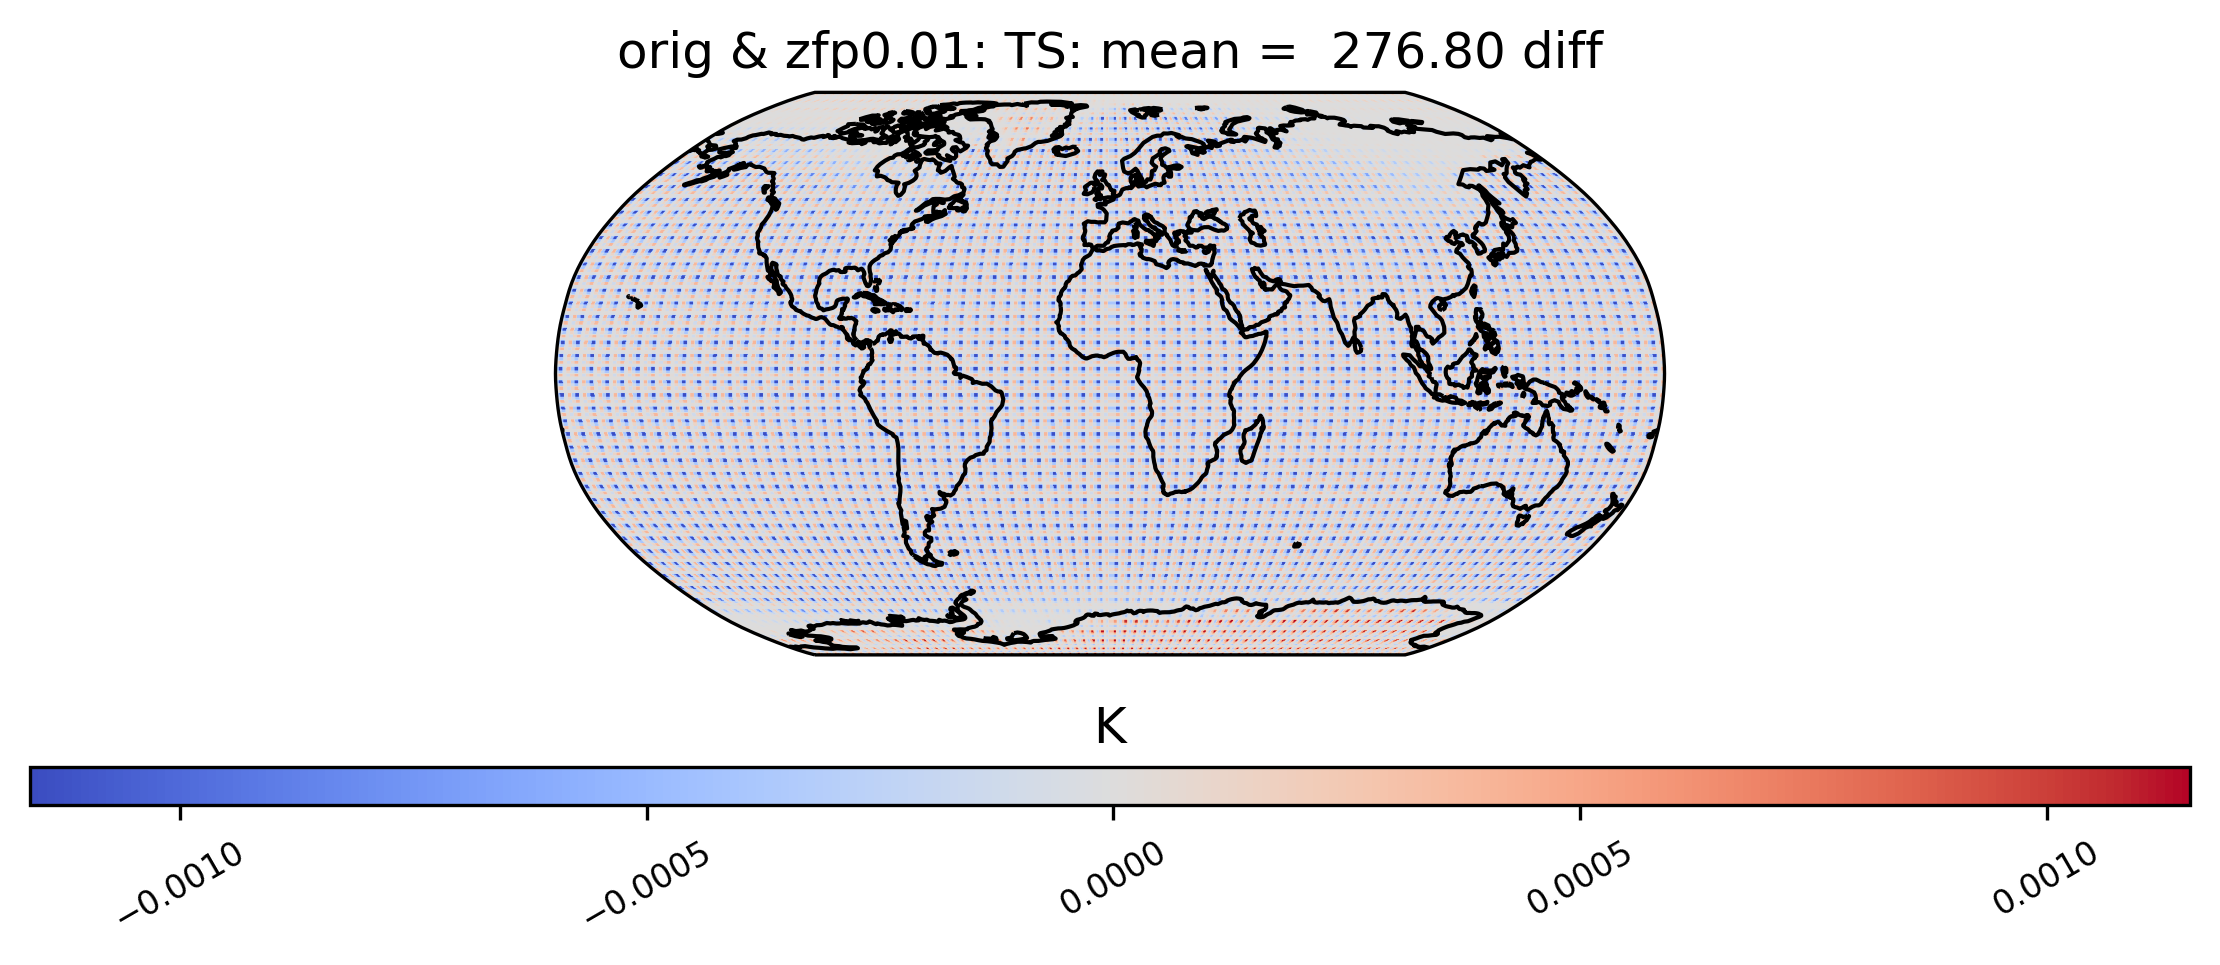

In [17]:
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "zfp0.01"],
    calc="mean",
    calc_type="diff",
)

Now we look at two other (improved) variants of zfp, called ZFP-beta and
ZFP-round.


In [18]:
col_TS_zfp = ldcpy.open_datasets(
    "cam-fv",
    ["TS"],
    [
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/orig/b.e11.B20TRC5CNBDRD.f09_g16.030.cam.h1.TS.19200101-20051231.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpbeta1.0.TS.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpbeta0.1.TS.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpbeta0.01.TS.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpround1.0.TS.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpround0.1.TS.nc",
        "/glade/campaign/cisl/asap/ldcpy_sample_data/cageo/lossy/zfpround0.01.TS.nc",
    ],
    [
        "orig",
        "zfpbeta1.0",
        "zfpbeta0.1",
        "zfpbeta0.01",
        "zfpround1.0",
        "zfpround0.1",
        "zfpround0.01",
    ],
    chunks={"time": 500},
)
col_TS_zfp

dataset size in GB 38.87



<xarray.Dataset>
Dimensions:     (collection: 7, time: 25100, lat: 192, lon: 288)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 1920-01-01 00:00:00 ... 1988-10-07 00:00:00
    cell_area   (lat, collection, lon) float64 dask.array<chunksize=(192, 1, 288), meta=np.ndarray>
  * collection  (collection) <U12 'orig' 'zfpbeta1.0' ... 'zfpround0.01'
Data variables:
    TS          (collection, time, lat, lon) float32 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
Attributes: (12/16)
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.B20TRC5CNBDRD.f09_g16.030
    title:            UNSET
    logname:          mai
    host:             ys0110
    ...               ...
    history:          Wed Oct 29 04:21:35 2014: ncks -F -d time,1,31390 b.e11...
    NCO:              4.4.4
    cell_measures:    area: cell_area
    data_type:        cam-fv
    file_size:        {'orig': 4041565162, 'zfpbeta1.0': 6952629951, 'zfpbeta...
    weighted:         True

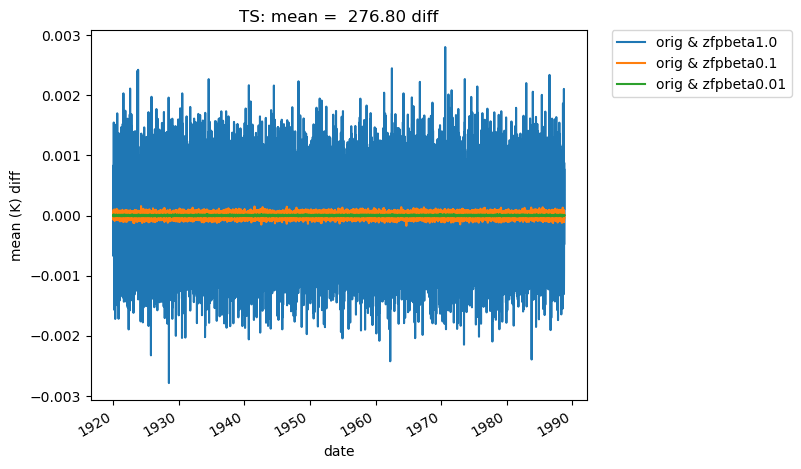

In [19]:
# zfp-beta
ldcpy.plot(
    col_TS_zfp,
    "TS",
    sets=["orig", "zfpbeta1.0", "zfpbeta0.1", "zfpbeta0.01"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

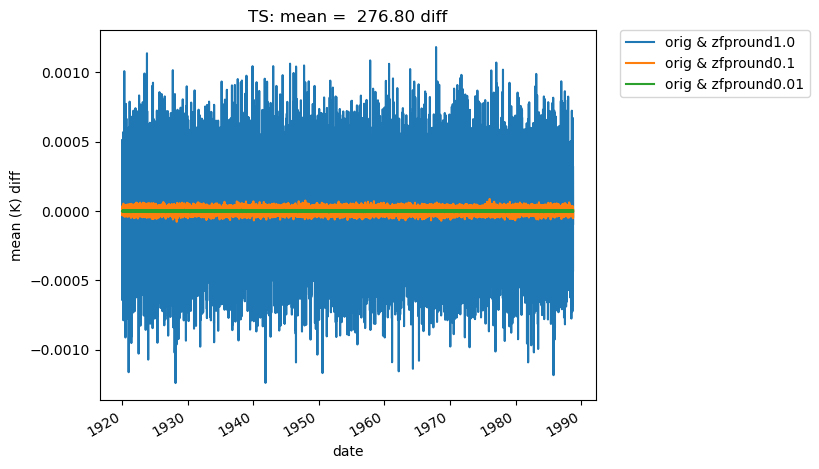

In [20]:
# zfp-round
ldcpy.plot(
    col_TS_zfp,
    "TS",
    sets=["orig", "zfpround1.0", "zfpround0.1", "zfpround0.01"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

Both of the above have an error distribution more like we would expect (mean ~ 0
). For comparison, we can plot the SZ compressor as well.


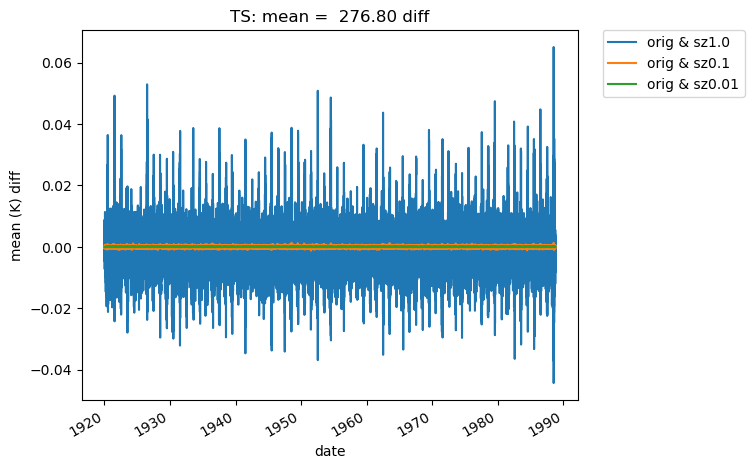

In [21]:
# Time-series plot of TS mean diff from orig with sz
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "sz1.0", "sz0.1", "sz0.01"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

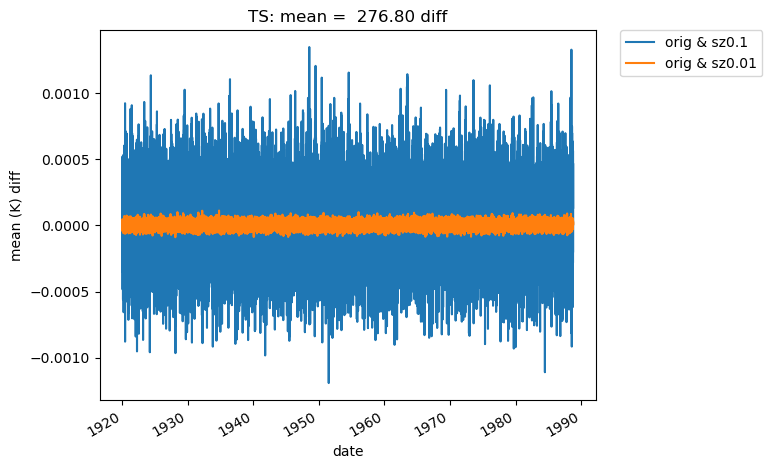

In [22]:
# same plot as above but just the smaller two tolerances
# Time-series plot of TS mean diff from orig with sz
ldcpy.plot(
    col_TS_cageo,
    "TS",
    sets=["orig", "sz0.1", "sz0.01"],
    calc="mean",
    plot_type="time_series",
    calc_type="diff",
)

In [23]:
client.shutdown()